<a href="https://colab.research.google.com/github/mbjallow6/Algorithms-python/blob/main/Computer_Vision_Group_Coding_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ⬛ COLAB-ONLY CELL – installs once per session (≈ 1 min)
!pip install --quiet torch torchvision pytorch-msssim scikit-image matplotlib pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.3 MB/s eta 0:00:00


In [2]:
import torch, torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import numpy as np, random, math, pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from pytorch_msssim import ssim as ssim_pt  # differentiable SSIM for loss if desired
from tqdm.notebook import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED   = 42
BATCH  = 16
EPOCHS = 10
LR     = 1e-3
NOISE_STD = 0.2
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


In [3]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor()
])

raw_ds = torchvision.datasets.STL10(root='data', split='train', download=True, transform=transform)
indices = random.sample(range(len(raw_ds)), 100)
train_idx, test_idx = indices[:80], indices[80:]
train_ds, test_ds   = Subset(raw_ds, train_idx), Subset(raw_ds, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)


100%|██████████| 2.64G/2.64G [02:06<00:00, 20.9MB/s]


In [4]:
def add_noise(x, std=NOISE_STD):
    noise = torch.randn_like(x) * std
    return (x + noise).clamp(0., 1.)


In [5]:
class DenoiseAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1,  3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model     = DenoiseAE().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [6]:
history = {'epoch': [], 'train_loss': [], 'test_loss': []}

for epoch in range(1, EPOCHS+1):
    # train
    model.train(); running = 0.
    for x,_ in train_loader:
        x, x_noisy = x.to(DEVICE), add_noise(x).to(DEVICE)
        optimizer.zero_grad(); out = model(x_noisy); loss = criterion(out, x)
        loss.backward(); optimizer.step(); running += loss.item()*x.size(0)
    train_loss = running / len(train_ds)

    # evaluate
    model.eval(); running = 0.
    with torch.no_grad():
        for x,_ in test_loader:
            x, x_noisy = x.to(DEVICE), add_noise(x).to(DEVICE)
            running += criterion(model(x_noisy), x).item()*x.size(0)
    test_loss = running / len(test_ds)

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)


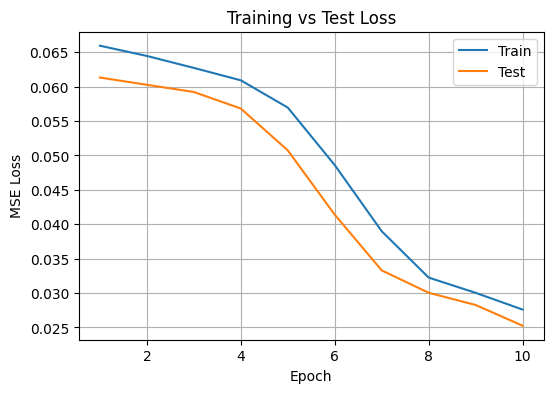

In [7]:
plt.figure(figsize=(6,4))
plt.plot(history['epoch'], history['train_loss'], label='Train')
plt.plot(history['epoch'], history['test_loss'],  label='Test')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title('Training vs Test Loss');
plt.legend(); plt.grid(True); plt.show()


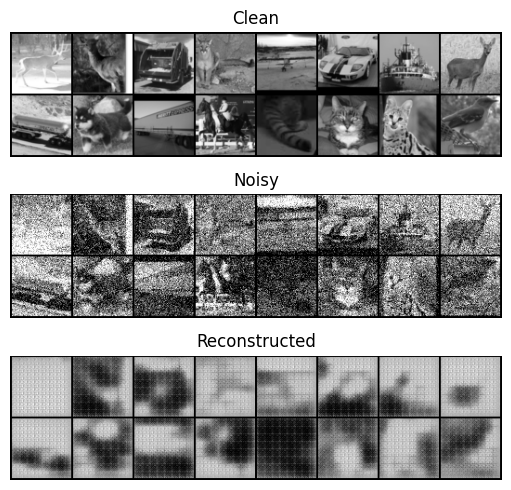

In [8]:
model.eval(); x,_ = next(iter(test_loader)); x_noisy = add_noise(x)
with torch.no_grad(): x_hat = model(x_noisy.to(DEVICE)).cpu()

def imgrid(t):
    return torchvision.utils.make_grid(t, nrow=8, padding=2, normalize=True)

fig,axs = plt.subplots(3,1, figsize=(12,5))
for ax, img, ttl in zip(axs, [x, x_noisy, x_hat], ['Clean', 'Noisy', 'Reconstructed']):
    ax.imshow(imgrid(img).permute(1,2,0), cmap='gray'); ax.set_title(ttl); ax.axis('off')
plt.tight_layout(); plt.show()


In [9]:
def batch_metrics(clean, recon):
    clean = clean.squeeze(1).cpu().numpy(); recon = recon.squeeze(1).cpu().numpy()
    psnrs, ssims = [], []
    for c,r in zip(clean, recon):
        psnrs.append(psnr(c, r, data_range=1))
        ssims.append(ssim(c, r, data_range=1))
    return np.mean(psnrs), np.mean(ssims)

# Train metrics
model.eval(); tr_clean, tr_recon = [], []
with torch.no_grad():
    for x,_ in train_loader:
        x_noisy = add_noise(x).to(DEVICE)
        tr_clean.append(x)
        tr_recon.append(model(x_noisy).cpu())
train_psnr, train_ssim = batch_metrics(torch.cat(tr_clean), torch.cat(tr_recon))

# Test metrics
te_clean, te_recon = [], []
with torch.no_grad():
    for x,_ in test_loader:
        x_noisy = add_noise(x).to(DEVICE)
        te_clean.append(x)
        te_recon.append(model(x_noisy).cpu())

test_psnr, test_ssim = batch_metrics(torch.cat(te_clean), torch.cat(te_recon))

pd.DataFrame({
    'Split' : ['Train','Test'],
    'MSE Loss' : [history['train_loss'][-1], history['test_loss'][-1]],
    'PSNR (dB)': [train_psnr, test_psnr],
    'SSIM'     : [train_ssim,  test_ssim]
}).set_index('Split')


,MSE Loss,PSNR (dB),SSIM
Split,,,
Train,0.027596,16.378381,0.226638
Test,0.025251,16.497401,0.225323
